# PWR Baseline
This notebook is intended to compute the neutron energy spectrum for a "baseline" PWR similar, for example, to an AP1000

In [1]:
import openmc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
# define the fuel material
fuel = openmc.Material(name='fuel');
fuel.set_density('g/cm3',10.45);
# use atom fractions for 4 a/o U-235. 
fuel.add_element('U',1, percent_type='ao',enrichment=4.0);
fuel.add_nuclide('O16',2.0);

# ignore the gap gas (negligible impact on neutron energy)

# just use elemental Zirconium for clad.
clad = openmc.Material(name='clad');
clad.add_element('Zr',1);
clad.set_density('g/cm3',6.0);

mod = openmc.Material(name='moderator');
mod.add_element('O',1);
mod.add_element('H',2);
mod.set_density('g/cm3',0.712); #high temperature density
mod.add_s_alpha_beta('c_H_in_H2O');

# create Materials object and export to xml
materials = openmc.Materials([fuel,clad,mod]);
materials.export_to_xml();

In [7]:
# define the pin cell geometry
h_core = 500.;
h_fuel = 426.7;

r_o = 0.819/2.; #cm, fuel outer radius
r_ci = r_o +  0.008255; # clad inner radius 
r_co = 0.95/2.; # clad outer radius

P_D = 1.326;

pitch = P_D*(2*r_co);

#fuel cylinder
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel,r_o);
fuel.volume = np.pi*(r_o**2)*h_fuel;

# clad inner cylinder
cladi_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                              h_fuel,r_ci);
# clad outer cylinder
clado_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                              h_fuel,r_co);
# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');


fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;

gap_cell = openmc.Cell();
gap_cell.region = +fuel_cyl & -cladi_cyl;
gap_cell.fill = None; # same as "void"

clad_cell = openmc.Cell();
clad_cell.region = +cladi_cyl & -clado_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +clado_cyl & -core_cell;
mod_cell.fill = mod;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,gap_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

geometry.export_to_xml();





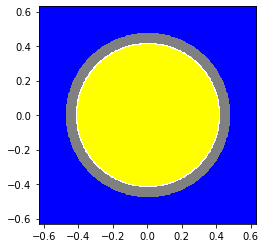

In [8]:
colors = {}
colors[fuel]='yellow'
colors[mod] = 'blue'
colors[clad] = 'grey'

root_univ.plot(width=(pitch,pitch),pixels=[400,400],
               color_by='material',colors=colors);


In [9]:
# create tally to determine flux energy spectrum in the fuel

cell_filter = openmc.CellFilter(fuel_cell);

# set up energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish flux tally
flux = openmc.Tally(name='flux');
flux.scores = ['flux'];
flux.filters = [cell_filter,energy_filter];

tallies = openmc.Tallies([flux]);
tallies.export_to_xml()


In [11]:
# establish settings for a criticality calculation
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-r_o,-r_o,-h_fuel/2.),
                      upper_right = (r_o,r_o,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;
settings.export_to_xml();

In [12]:
# run openmc
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      137/1    1.39831    1.39208 +/- 0.00122
      138/1    1.39389    1.39210 +/- 0.00120
      139/1    1.40075    1.39220 +/- 0.00119
      140/1    1.38860    1.39216 +/- 0.00118
      141/1    1.41563    1.39242 +/- 0.00120
      142/1    1.38410    1.39233 +/- 0.00119
      143/1    1.38931    1.39230 +/- 0.00117
      144/1    1.38699    1.39224 +/- 0.00116
      145/1    1.40497    1.39237 +/- 0.00116
      146/1    1.38957    1.39234 +/- 0.00115
      147/1    1.37850    1.39220 +/- 0.00114
      148/1    1.40594    1.39234 +/- 0.00114
      149/1    1.40612    1.39248 +/- 0.00114
      150/1    1.39785    1.39253 +/- 0.00113
      151/1    1.39187    1.39253 +/- 0.00112
      152/1    1.38747    1.39248 +/- 0.00111
      153/1    1.39080    1.39246 +/- 0.00110
      154/1    1.39136    1.39245 +/- 0.00109
      155/1    1.39896    1.39251 +/- 0.00108
      156/1    1.39481    1.39253 +/- 0.00107
      157/1    1.36721    1.39230 +/- 0.00108
      158/1    1.39393    1.39231 

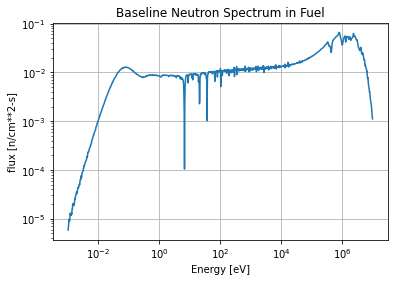

In [13]:
# get tally result and plot flux energy spectrum
sp = openmc.StatePoint('statepoint.200.h5')

flux_t = sp.get_tally(name='flux');
flux_df = flux_t.get_pandas_dataframe();
flux_vals = flux_df['mean'].to_numpy();

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,flux_vals);
plt.grid();
plt.title('Baseline Neutron Spectrum in Fuel');
plt.xlabel('Energy [eV]');
plt.ylabel('flux [n/cm**2-s]');